In [39]:
import pandas as pd 
import pingouin as pg 
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import optuna

In [3]:
#carregar dataset
df_segmento = pd.read_csv('./datasets/clientes.csv')

### EDA

In [4]:
df_segmento.head(10)

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver
5,Serviços,1629562.41,16,Rio de Janeiro,11,4,Silver
6,Serviços,771179.95,13,Vitória,0,1,Starter
7,Serviços,707837.61,16,São Paulo,10,6,Silver
8,Comércio,888983.66,17,Belo Horizonte,10,1,Bronze
9,Indústria,1098512.64,13,Rio de Janeiro,9,3,Bronze


In [5]:
# estrutura do dataset
df_segmento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [6]:
# Valores possiveis - Atividades categoricas
df_segmento['atividade_economica'].unique()

array(['Comércio', 'Indústria', 'Agronegócio', 'Serviços'], dtype=object)

In [7]:
# Valores possiveis - Atividades categoricas
df_segmento['localizacao'].unique()

array(['Rio de Janeiro', 'São Paulo', 'Vitória', 'Belo Horizonte'],
      dtype=object)

In [8]:
# Valores possiveis - Atividades categoricas
df_segmento['segmento_de_cliente'].unique()

array(['Bronze', 'Silver', 'Starter', 'Gold'], dtype=object)

In [9]:
# Valores possiveis - Atividades categoricas
df_segmento['inovacao'].unique()

array([1, 0, 9, 8, 4, 6, 3, 7, 5, 2])

In [10]:
# Variavel de segmento de cliente (target)
contagem_target = df_segmento.value_counts('segmento_de_cliente')
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [11]:
# lista ordenada
lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

In [12]:
# Distribuição da variavel target - contagem
px.bar(contagem_target, color=contagem_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [13]:
# Distribuição da variavel target - percentual
percentual_target = contagem_target / len(df_segmento) * 100
px.bar(percentual_target, color=percentual_target.index, category_orders={'segmento_de_cliente': lista_segmentos})

In [14]:
# Distribuição da variavel target - percentual
percentual_localizacao = df_segmento.value_counts('localizacao') / len(df_segmento) * 100
px.bar(percentual_localizacao, color=percentual_localizacao.index)

In [15]:
# Distribuição da variavel target - percentual
percentual_atividade_economica = df_segmento.value_counts('atividade_economica') / len(df_segmento) * 100
px.bar(percentual_atividade_economica, color=percentual_atividade_economica.index)

In [16]:
# Distribuição da variavel target - percentual
percentual_inovacao = df_segmento.value_counts('inovacao') / len(df_segmento) * 100
px.bar(percentual_inovacao, color=percentual_inovacao.index)

In [20]:
# tabela de contingencia entre localização e target
crosstab_localizacao = pd.crosstab(df_segmento['localizacao'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_localizacao = ff.create_table(crosstab_localizacao)
tabela_localizacao.show()

In [21]:
# tabela de contingencia entre atividade economica e target
crosstab_atividade_economica = pd.crosstab(df_segmento['atividade_economica'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_atividade_economica = ff.create_table(crosstab_atividade_economica)
tabela_atividade_economica.show()

In [22]:
# tabela de contingencia entre inovação e target
crosstab_inovacao = pd.crosstab(df_segmento['inovacao'], df_segmento['segmento_de_cliente'], margins=True)[lista_segmentos].reset_index()
tabela_inovacao = ff.create_table(crosstab_inovacao)
tabela_inovacao.show()

In [23]:
# histogragrma distribuicao idade da empresa
px.histogram(df_segmento.idade)

In [24]:
# histogragrma distribuicao faturamento_mensal da empresa
px.histogram(df_segmento.faturamento_mensal)

In [26]:
#boxplot entre idade e segmento
px.box(df_segmento, x='segmento_de_cliente', y='idade', color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [27]:
#boxplot entre faturamento_mensal e segmento
px.box(df_segmento, x='segmento_de_cliente', y='faturamento_mensal', color='segmento_de_cliente', category_orders={'segmento_de_cliente': lista_segmentos})

In [28]:
# Teste Qui quadrado de pearson
# H0 = as variaveis sao independentes e H1 nao sao
# se pvalue > 0.05 aceita hipotese nula
valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_segmento, 'segmento_de_cliente', 'localizacao')

c:\Users\USER\.virtualenvs\arvore_decisao-4M1uiDjv\Lib\site-packages\pingouin\contingency.py:151: UserWarning:

Low count on observed frequencies.

c:\Users\USER\.virtualenvs\arvore_decisao-4M1uiDjv\Lib\site-packages\pingouin\contingency.py:151: UserWarning:

Low count on expected frequencies.



In [29]:
#valor esperado é a frequencia que seria esperada se nao houvesse associação entre as variaveis
# Calcula utilizando a distribuição assumida do teste do quiquadrado
valor_esperado


localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,44.844,52.924,48.884,55.348
Gold,3.552,4.192,3.872,4.384
Silver,57.720,68.120,62.920,71.240
Starter,4.884,5.764,5.324,6.028


In [30]:
#frequencia real dos dados
valor_observado

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,39,62,45,56
Gold,4,3,5,4
Silver,63,60,65,72
Starter,5,6,6,5


In [31]:
#estatisticas
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,5.19335,9.0,0.81714,0.05884,0.11369
1,cressie-read,0.66667,5.19198,9.0,0.81726,0.05883,0.11367
2,log-likelihood,0.00000,5.19713,9.0,0.81680,0.05886,0.11374
3,freeman-tukey,-0.50000,5.20798,9.0,0.81581,0.05892,0.11390
4,mod-log-likelihood,-1.00000,5.22494,9.0,0.81428,0.05902,0.11414
5,neyman,-2.00000,5.27777,9.0,0.80945,0.05932,0.11490


As variaveis localizaçao e segmento de cliente sao independentes pvalue = 0.81
atividade economica = pvalue = 0.35 tbm independente 
inovacao = pvalue = 0.0 Há uma correlação, as variaveis nao sao independentes

### Treinar modelo arvore

In [32]:
X = df_segmento.drop(columns=['segmento_de_cliente'])
y = df_segmento['segmento_de_cliente']

In [33]:
# Pipeline
# Onehotenconde nas variveis categoricas 
# Treinamento do modelo

# lista de variavis categoricas
categorical_features = ['atividade_economica', 'localizacao']

# criar um transformador e variaveis categoricas usando o onehotencoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Pipeline com Pre processor e o modelo de arvore de decisão
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])

### Validação cruzada

In [42]:
#treinar o modelo com validação cruzada usando stratifielkfold, dado que as classe estão desbalanceadas
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)
metrics_result = cross_validate(dt_model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)

In [44]:
# mostrar o retorno do cross validation
metrics_result

{'fit_time': array([0.02619481, 0.00885415, 0.0084753 ]),
 'score_time': array([0.07059765, 0.02458811, 0.00714588]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('imputer',
        

In [45]:
#media da acurácia considerando os tres splits
metrics_result['test_accuracy'].mean()

np.float64(0.4739917754851743)

In [ ]:
# acuracia 
# total de previsoes corretas  / sobre o total de previsoes


### Métricas

In [46]:
# Fazendo predições usando cross validation
y_pred = cross_val_predict(dt_model, X, y, cv=cv_folds)

In [47]:
# avalia o desempenho 
classification_report_str = classification_report(y, y_pred)
print(f'Relatorio de classificaçãi: \n{classification_report_str}')

Relatorio de classificaçãi: 
              precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



c:\Users\USER\.virtualenvs\arvore_decisao-4M1uiDjv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\USER\.virtualenvs\arvore_decisao-4M1uiDjv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\USER\.virtualenvs\arvore_decisao-4M1uiDjv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



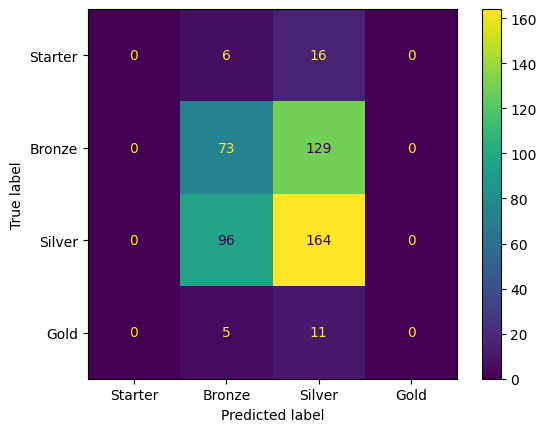

In [49]:
# mostrar matriz de confusão
confusion_matrix_modelo = confusion_matrix(y, y_pred, labels=lista_segmentos)
disp = ConfusionMatrixDisplay(confusion_matrix_modelo, display_labels=lista_segmentos)
disp.plot()

### Tuning de hiperparamentros

In [51]:
# ajustar hiperparamentros usando optuna
# min_samples_leaf = minimo de instancias requerido para formar uma folha(nó terminal)
# max_depth = profundidade maxima da arvore

def decisiontree_optuna(trial):
    min_sample_leaf = trial.suggest_int('min_sample_leaf', 1, 20)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    
    dt_model.set_params(classifier__min_samples_leaf=min_sample_leaf)
    dt_model.set_params(classifier__max_depth=max_depth)
    
    
    scores = cross_val_score(dt_model, X, y, cv=cv_folds, scoring='accuracy')
    
    return scores.mean()

In [53]:
# executar a automação de experimentos
estudo_decisiontree = optuna.create_study(direction='maximize')
estudo_decisiontree.optimize(decisiontree_optuna, n_trials=200)

[I 2025-05-31 11:29:09,646] A new study created in memory with name: no-name-cac9a3fb-39e5-489d-a41d-a6ce2923f82b


[I 2025-05-31 11:29:09,752] Trial 0 finished with value: 0.4519755669384123 and parameters: {'min_sample_leaf': 18, 'max_depth': 4}. Best is trial 0 with value: 0.4519755669384123.
[I 2025-05-31 11:29:09,838] Trial 1 finished with value: 0.4620037034365005 and parameters: {'min_sample_leaf': 20, 'max_depth': 2}. Best is trial 1 with value: 0.4620037034365005.
[I 2025-05-31 11:29:09,904] Trial 2 finished with value: 0.4740518962075848 and parameters: {'min_sample_leaf': 5, 'max_depth': 2}. Best is trial 2 with value: 0.4740518962075848.
[I 2025-05-31 11:29:09,977] Trial 3 finished with value: 0.4739917754851743 and parameters: {'min_sample_leaf': 1, 'max_depth': 7}. Best is trial 2 with value: 0.4740518962075848.
[I 2025-05-31 11:29:10,035] Trial 4 finished with value: 0.4699877353726283 and parameters: {'min_sample_leaf': 13, 'max_depth': 3}. Best is trial 2 with value: 0.4740518962075848.
[I 2025-05-31 11:29:10,102] Trial 5 finished with value: 0.4699877353726283 and parameters: {'min

In [54]:
# mostrra melhor resultado e melhor conjunto de hiperparametros
print(f'melhor acuracia: {estudo_decisiontree.best_value}')
print(f'melhor parametro: {estudo_decisiontree.best_params}')

melhor acuracia: 0.4740518962075848
melhor parametro: {'min_sample_leaf': 5, 'max_depth': 2}


### Visualizar arvore

In [61]:
# Preparar o conjunto de dados para treinar e visualizar a árvore
X_train_tree = X.copy()

# Converter colunas categóricas para códigos numéricos
X_train_tree['localizacao_label'] = X_train_tree.localizacao.astype('category').cat.codes
X_train_tree['atividade_economica_label'] = X_train_tree.atividade_economica.astype('category').cat.codes

# Remover as colunas originais (não numéricas)
X_train_tree.drop(columns=['localizacao', 'atividade_economica'], axis=1, inplace=True)
X_train_tree.rename(columns={'localizacao_label': 'localizacao', 'atividade_economica_label': 'atividade_economica'}, inplace=True)

X_train_tree.head(10)

,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0
5,1629562.41,16,11,4,1,3
6,771179.95,13,0,1,3,3
7,707837.61,16,10,6,2,3
8,888983.66,17,10,1,0,1
9,1098512.64,13,9,3,1,2


In [62]:
#treinar o modelo com o conjunto de hiperparametros ideal
clf_decisiontree = DecisionTreeClassifier(min_samples_leaf=estudo_decisiontree.best_params['min_sample_leaf'],
                                          max_depth=estudo_decisiontree.best_params['max_depth'])

y_tran_tree = y.copy()

clf_decisiontree.fit(X_train_tree, y_tran_tree)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

[Text(0.5, 0.8333333333333334, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.25, 0.5, 'faturamento_mensal <= 425959.422\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.26\nsamples = 13\nvalue = [2, 0, 0, 11]\nclass = Gold'),
 Text(0.375, 0.16666666666666666, 'gini = 0.421\nsamples = 152\nvalue = [110, 0, 35, 7]\nclass = Starter'),
 Text(0.75, 0.5, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = Starter'),
 Text(0.875, 0.16666666666666666, 'gini = 0.416\nsamples = 298\nvalue = [64.0, 16.0, 218.0, 0.0]\nclass = Silver')]

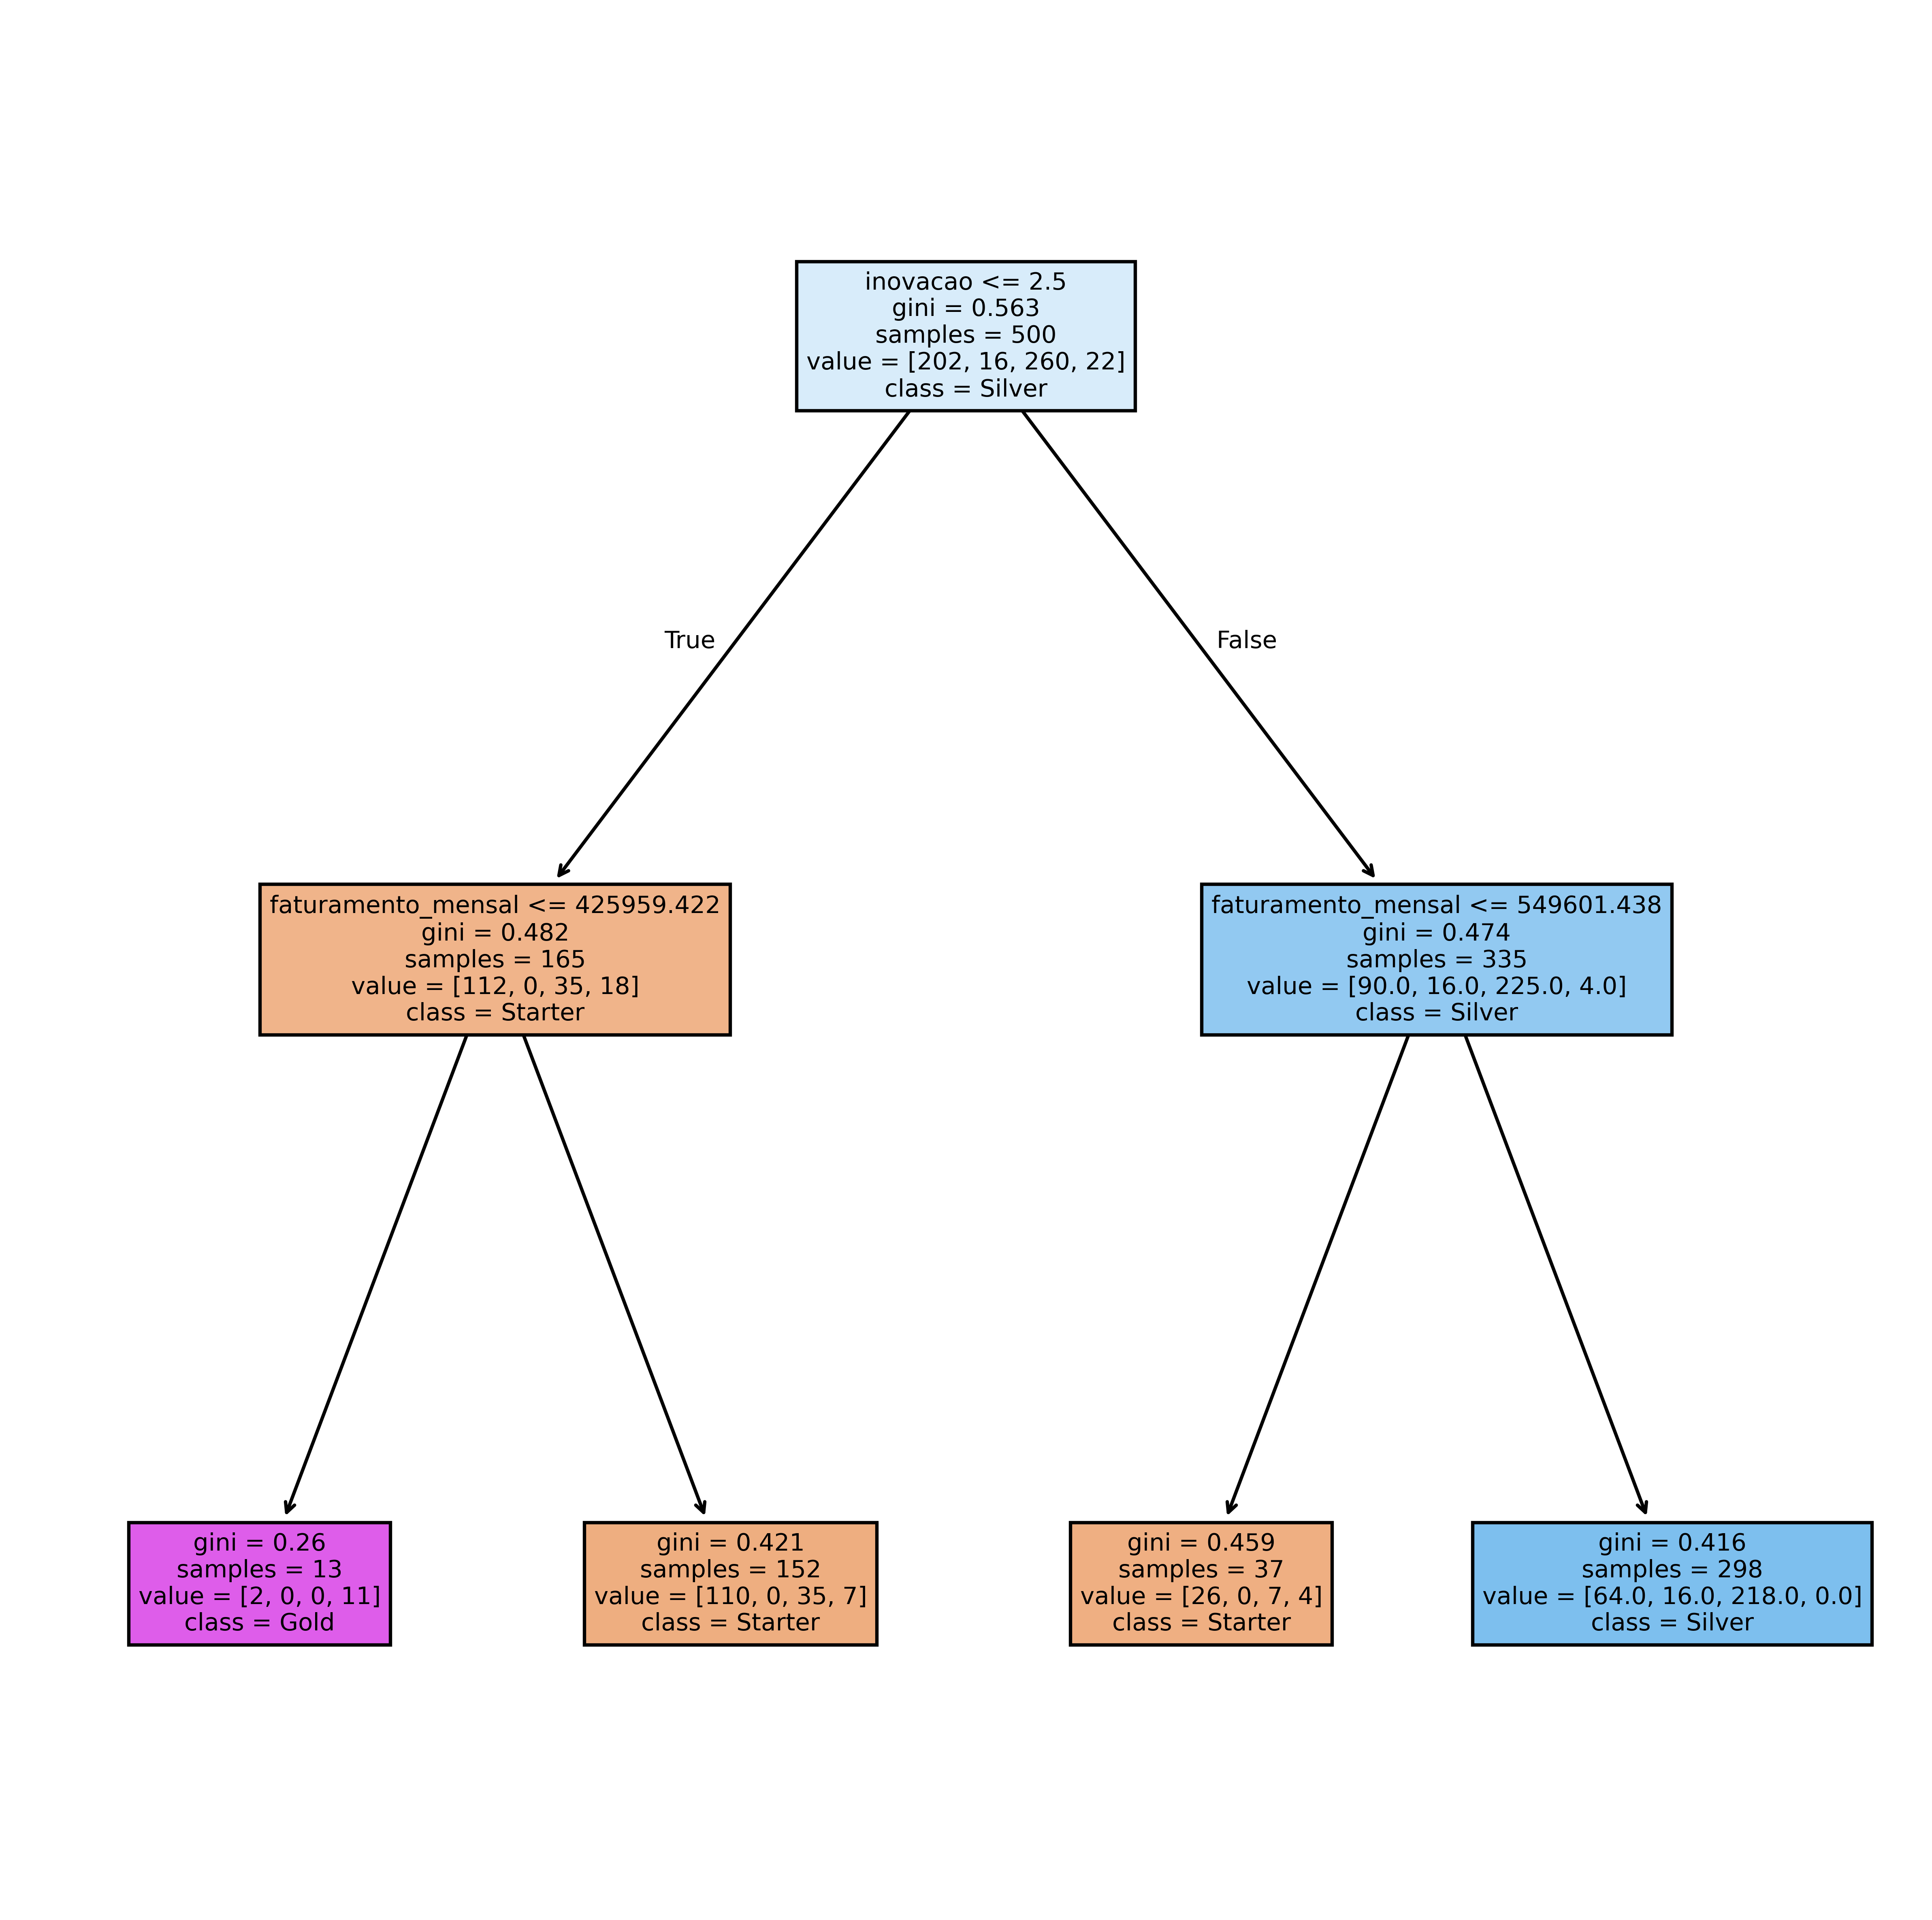

In [66]:
# visualizar arvore de decisão plot tree
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10), dpi=600)

plot_tree(clf_decisiontree,
          feature_names=X_train_tree.columns.to_numpy(),
          class_names=lista_segmentos,
          filled=True)

In [67]:
# salvar modelo
import joblib

# criar um pipeline tunado
dt_model_tunado = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', DecisionTreeClassifier(min_samples_leaf=estudo_decisiontree.best_params['min_sample_leaf'],
                                          max_depth=estudo_decisiontree.best_params['max_depth'])
 )])

# Treinar

dt_model_tunado.fit(X, y)

#salvar modelo
joblib.dump(dt_model_tunado, 'modelo_decicion_tree.pkl')

['modelo_decicion_tree.pkl']

### Entregar modelo predição batch

In [70]:
import gradio as gr
import pandas as pd
import joblib

# Load your model
modelo = joblib.load('./modelo_decision_tree.pkl')

def predict(arquivo):
    # Read the uploaded CSV file
    df_empresas = pd.read_csv(arquivo)
    
    # Make predictions
    y_pred = modelo.predict(df_empresas)
    
    # Combine predictions with original data
    df_segmentos = pd.DataFrame(y_pred, columns=['segmento_de_cliente'])
    df_predicoes = pd.concat([df_empresas, df_segmentos], axis=1)
    
    # Save predictions
    df_predicoes.to_csv('./predicoes.csv', index=False)
    return './predicoes.csv'

# Create the Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.File(file_types=['.csv']),
    outputs=gr.File(label="Download predictions"),
    title="Customer Segment Predictor",
    description="Upload a CSV file to get customer segment predictions"
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
